In [1]:
import numpy as np
import os
import os.path as osp
import tonic
import sys
sys.path.append('../')
from datasets_torch_geometric.dataset_factory import create_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
from pathlib import Path

import copy
from utils.config_utils import get_checkpoint_file, get_config_file, show_cfg
from omegaconf import OmegaConf
from transform_factory import factory as transforms
import torch_geometric.transforms as T
from datatransforms.event_transforms import *
from IPython.display import HTML

from graph_data_module import GraphDataModule
from typing import Union, Iterable, List, Tuple

import torch
from utils.visualize_utils import animate_events

import pytorch_lightning as pl

from models.est import create_image
import model_factory
from train import Runner
import torchmetrics
from utils.data_utils import pyg2numpy_event_convertor
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
is_saving_allowed = True

entity = 'haraghi'
folder_name = 'paper'
experiment_folder_name = 'ncars_analyze'

assert not is_saving_allowed, "Are you sure? Please set is_saving_allowed to False."

AssertionError: Are you sure? Please set is_saving_allowed to False.

In [3]:
subfolder_name = os.path.join('../images/subsampling_methods',folder_name,experiment_folder_name)
if is_saving_allowed:
    if not os.path.exists(subfolder_name):
        os.makedirs(subfolder_name)
    # file_path = os.path.join(subfolder_name,"sparsity_vs_acc.tex")

In [4]:
# Load dictionary
data = torch.load('NCARS_acc_num_events.pt')

# Extract data properly
CM_outputs_dict = data.get('CM_outputs_dict')
num_event_dict = data.get('num_event_dict')
y_pred_dict = data.get('y_pred_dict')
y_true = data.get('y_true')

num_event_spatio = num_event_dict['spatiotemporal']
y_pred_spatio = y_pred_dict['spatiotemporal']
num_event_random = num_event_dict['random']
y_pred_random = y_pred_dict['random']
num_event_spatio_mean = num_event_dict['spatiotemporal_mean']
y_pred_spatio_mean = y_pred_dict['spatiotemporal_mean']


/tmp/ipykernel_36906/826287995.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('NCARS_acc_num_events.pt')


In [5]:
from sklearn.metrics import accuracy_score

# Define the bins
bins = np.arange(0, 1700, 50, dtype=float)

# Initialize lists to store accuracies for each bin
accuracies_spatio = []
accuracies_random = []
bin_centers = []

# Loop through bins
for i in range(len(bins) - 1):
    # Get bin edges
    bin_lower = bins[i]
    bin_upper = bins[i + 1]

    # Find indices of samples that fall into the current bin for spatiotemporal model
    bin_indices_spatio = np.where((num_event_spatio >= bin_lower) & (num_event_spatio < bin_upper))[0]
    if len(bin_indices_spatio) > 0:
        # Calculate accuracy for spatiotemporal model in the current bin
        accuracy_spatio = accuracy_score(y_true[bin_indices_spatio], y_pred_spatio[bin_indices_spatio])
        accuracies_spatio.append(accuracy_spatio)
    else:
        accuracies_spatio.append(np.nan)  # If no samples in this bin, set NaN

    # Find indices of samples that fall into the current bin for random model
    bin_indices_random = np.where((num_event_random >= bin_lower) & (num_event_random < bin_upper))[0]
    if len(bin_indices_random) > 0:
        # Calculate accuracy for random model in the current bin
        accuracy_random = accuracy_score(y_true[bin_indices_random], y_pred_random[bin_indices_random])
        accuracies_random.append(accuracy_random)
    else:
        accuracies_random.append(np.nan)  # If no samples in this bin, set NaN

    # Save the bin center for plotting
    bin_centers.append((bin_lower + bin_upper) / 2)

# Convert lists to numpy arrays for plotting
bin_centers = np.array(bin_centers)
accuracies_spatio = np.array(accuracies_spatio)
accuracies_random = np.array(accuracies_random)

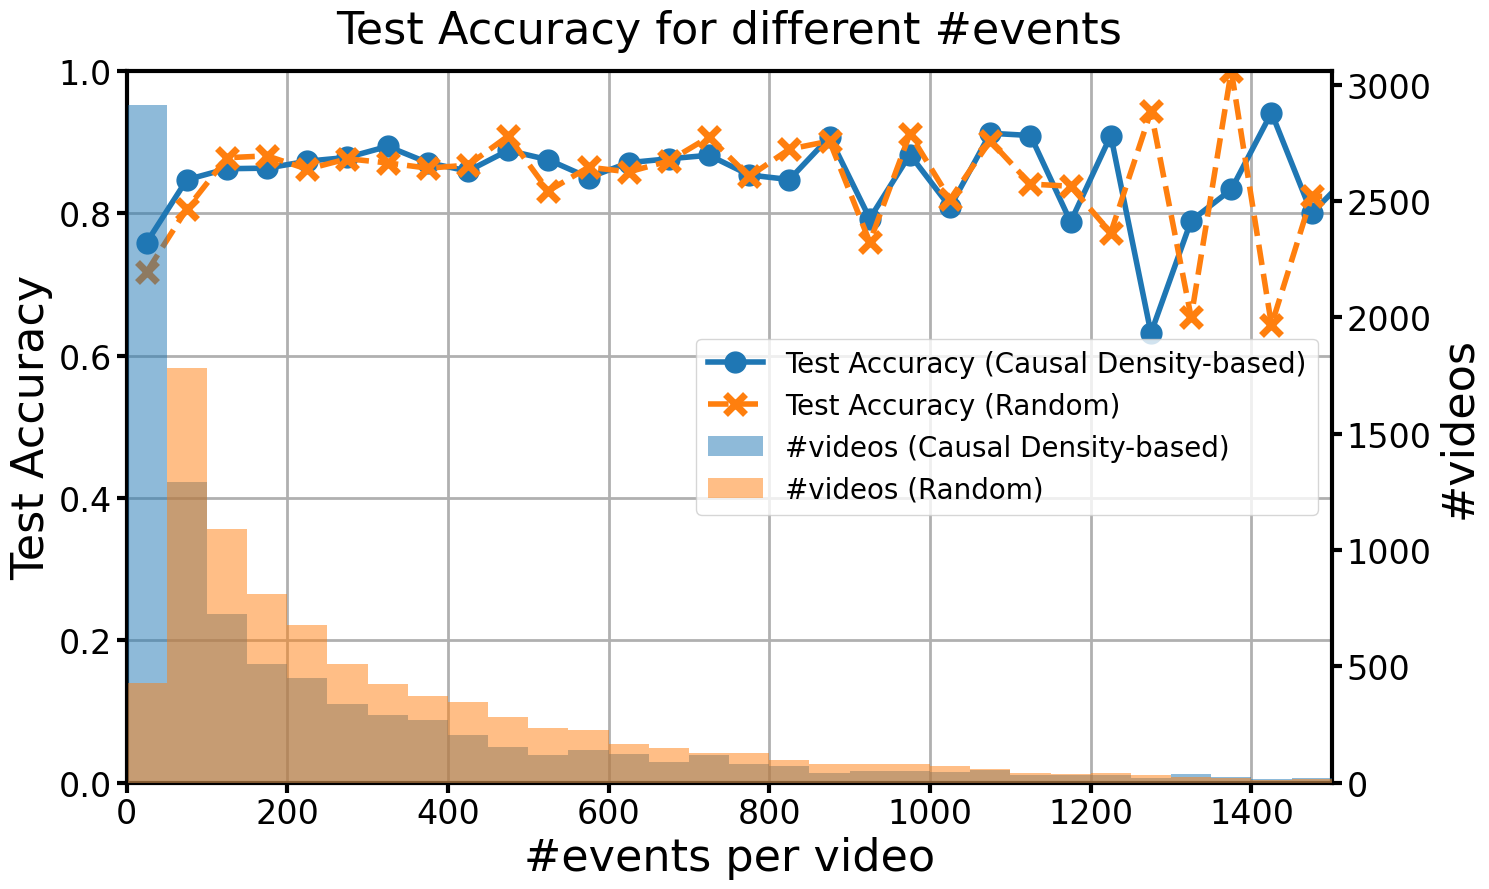

In [9]:
# Plot the results
fig, ax1 = plt.subplots(figsize=(15, 9))
ax1.plot(bin_centers, accuracies_spatio, label='Test Accuracy (Causal Density-based)', marker='o' ,markersize=15, linestyle='-', linewidth=4)
ax1.plot(bin_centers, accuracies_random, label='Test Accuracy (Random)', marker='x',markersize=15, markeredgewidth=5, linestyle='--', linewidth=4)

ax1.set_xlabel('#events per video', fontsize=32) 
ax1.set_ylabel('Test Accuracy', fontsize=32) 
ax1.tick_params(axis='both',  which='both', width=3, length=7, labelsize=24)
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1500])

ax2 = ax1.twinx()
ax2.hist(num_event_spatio, bins=bins, alpha=0.5, label='#videos (Causal Density-based)')
ax2.hist(num_event_random, bins=bins, alpha=0.5, label='#videos (Random)')
ax2.set_ylabel('#videos', fontsize=32)
ax2.tick_params(axis='y',  which='both', width=3, length=7, labelsize=24)

ax1.grid(axis='x' , linewidth=2)  # Adjust as needed
ax1.grid(axis='y', linewidth=2)  # Adjust as needed

for spine in ax1.spines.values():
    spine.set_linewidth(3)  # Adjust thickness as needed

plt.tight_layout()
plt.title('Test Accuracy for different #events', fontsize=32, pad=20)



# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='right', fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(subfolder_name,f'acc_num_events_ncars.pdf'))
plt.show()



In [10]:
print('type', ' '*(20-len('type')),
        '****  mean  ****', '\t\t',
        '****  std  ****', '\t',
        'min', '\t',
        'max', '\t',
        'median')
print('-'*100)
for key, value in num_event_dict.items():
    print(key, ' '*(20-len(key)),
          np.mean(value), '\t',
          np.std(value), '\t',
          np.min(value), '\t',
          np.max(value), '\t',
          np.median(value))


type                  ****  mean  **** 		 ****  std  **** 	 min 	 max 	 median
----------------------------------------------------------------------------------------------------
spatiotemporal        294.18624375508307 	 607.0569374443568 	 1 	 17107 	 105.0
spatiotemporal_mean   1014.9491111885675 	 1082.1918514780311 	 103 	 14715 	 636.0
random                338.9388869524805 	 361.22922921895616 	 28 	 4840 	 212.0
orig                  4067.7325432787266 	 4335.566786406965 	 500 	 59249 	 2545.0


In [2]:
dataset_names = ['DVSGESTURE_TONIC', 'NCARS', 'NASL', 'NCALTECH101', 'FAN1VS3']
api = wandb.Api()

In [9]:
dataset_name = 'NCARS'

experiments_dic = {
    "spatiotemporal": ["haraghi/Spatiotemporal_fixed_NCARS_100x120_42s/29r8p6zn"],
    # "spatiotemporal": ["haraghi/Spatiotemporal_fixed_NCARS_100x120_42s/sqisw4l2"],
    "spatiotemporal_mean": ["haraghi/Spatiotemporal_fixed_NCARS_100x120_42s_tau30_7x7_mean_normalized/u8ql7g6z"],
    "random": ["haraghi/Random_fixed_NCARS_100x120_42s/53na6hwm"],
}

remote_root = "/data/mybulk/event-based-GNN/DGCNN_CV_format/"
assert os.path.exists(remote_root), "Remote directory does not exist or is not accessible."

In [10]:
projects = api.projects(entity="haraghi")
for project in projects:
    if "NCARS" in project.name:
        print(project.name)

Spatial_NCARS_CORRECTED_OFFSET_100x120_12s
Spatial_NCARS_CORRECTED_OFFSET_100x120_42s
TOS_2D_Harris_NCARS_100x120_24s
TOS_2D_Harris_NCARS_100x120_12s
TOS_2D_Harris_NCARS_100x120_42s
Baseline_EventCount_NCARS_100x120_42s_spatial_upsampled
Baseline_EventCount_NCARS_100x120_42s
Spatiotemporal_fixed_NCARS_100x120_42s_tau30_7x7_mean_normalized
Spatiotemporal_fixed_NCARS_100x120_42s_tau100_5x5
Spatiotemporal_fixed_NCARS_100x120_42s_tau100_11x11
Spatiotemporal_fixed_NCARS_100x120_42s_tau100_9x9
Spatiotemporal_fixed_NCARS_100x120_42s_tau10
Spatiotemporal_fixed_NCARS_100x120_42s_tau100
Spatiotemporal_fixed_NCARS_100x120_42s
Random_fixed_NCARS_100x120_42s
Temporal_dataset_wide_random_offset_NCARS_100x120_42s
Spatial_dataset_wide_random_offsets_NCARS_100x120_42s
NCARS-in-memory
Spatial_dataset_wide_random_offsets_NCARS_42s
Temporal_dataset_wide_random_offsets_NCARS_42s
Spatiotemporal_fixed_NCARS_42s
Random_fixed_NCARS_42s
Subsamplimg-vs-bandwidth-NCARS
FINAL-NCARS-varyinig-sparsity


In [11]:
dataset_path = Path("/home/hesam/Projects/DGCNN_CV_format/datasets_torch_geometric/")

In [12]:
config_dict = {}
gdm_dict = {}
model_dict = {}
run_dict = {}
ckpt_dict = {}
runner_dict = {}
for exp, run_list in experiments_dic.items():
    config_dict[exp] = []
    gdm_dict[exp] = []
    model_dict[exp] = []
    run_dict[exp] = []
    ckpt_dict[exp] = []
    runner_dict[exp] = []
    for run in run_list:
        run_dict[exp].append(api.run(run))
        cfg,_ = get_config_file(*run.split("/"), verbose = True, cfg_bare='../config_bare.yaml')
        cfg.dataset.dataset_path = str(dataset_path / dataset_name / 'data')
        cfg.dataset.in_memory = False
        cfg.train.multi_test_num = 1
        ckpt_dict[exp].append(get_checkpoint_file(*run.split("/"), remote_root = remote_root))
        gdm_dict[exp].append(GraphDataModule(cfg))
        cfg.dataset.num_classes = gdm_dict[exp][-1].num_classes
        config_dict[exp].append(cfg)
        model_dict[exp].append(model_factory.factory(cfg))
        runner_dict[exp].append(Runner.load_from_checkpoint(ckpt_dict[exp][-1], cfg=cfg, model=model_dict[exp][-1]))


/tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/event-based-GNN/DGCNN_CV_format/pl_default_dir/Spatiotemporal_fixed_NCARS_100x120_42s/dry-wood-28/config.yml
cfg_file
--------------------------------------------------
{}

cfg
--------------------------------------------------
{}

loading checkpoint from /data/mybulk/event-based-GNN/DGCNN_CV_format/log_folder/Spatiotemporal_fixed_NCARS_100x120_42s/29r8p6zn/checkpoints/epoch=8-step=1188.ckpt
Number of classes: 2
/tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/event-based-GNN/DGCNN_CV_format/pl_default_dir/Spatiotemporal_fixed_NCARS_100x120_42s_tau30_7x7_mean_normalized/deft-bee-97/config.yml
cfg_file
--------------------------------------------------
{}

cfg
--------------------------------------------------
{}

Multiple checkpoints found, loading the latest one!
loading checkpoint from /data/mybulk/event-based-GNN/DGCNN_CV_format/log_folder/Spatiotemporal_fixed_NCARS_100x120_42s_tau30_7x7_mean_normalized/u8ql7g6z/checkpoints/epoch=

In [13]:
ds_orig = create_dataset(dataset_name = dataset_name,
                           dataset_path = str(dataset_path/dataset_name/"data"), 
                           dataset_type = "test")
ds_orig.transform = T.Compose([])

In [14]:
trainer = pl.Trainer(
    enable_progress_bar=True,
    # Use DDP training by default, even for CPU training
    # strategy="ddp_notebook",
    devices=torch.cuda.device_count(),
    accelerator="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
for exp, run_list in runner_dict.items():
    print(f"Testing {exp}:")
    for i in range(len(run_list)):
        print(f"run name: {run_dict[exp][i].name}")
        trainer.test(runner_dict[exp][i], datamodule=gdm_dict[exp][i])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing spatiotemporal:
run name: dry-wood-28


/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

Testing: |          | 0/? [00:00<?, ?it/s]

/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8267689347267151
      test/acc_mean         0.8267689347267151
      test/acc_std                  nan
        test/loss           0.5915024876594543
     test/loss_mean         0.5915024876594543
      test/loss_std                 nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing spatiotemporal_mean:
run name: deft-bee-97


/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

Testing: |          | 0/? [00:00<?, ?it/s]

/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8683629631996155
      test/acc_mean         0.8683629631996155
      test/acc_std                  nan
        test/loss           0.6956599950790405
     test/loss_mean         0.6956599950790405
      test/loss_std                 nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing random:
run name: blooming-pond-11


/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

Testing: |          | 0/? [00:00<?, ?it/s]

/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.8479145169258118
      test/acc_mean         0.8479145169258118
      test/acc_std                  nan
        test/loss           0.7892693281173706
     test/loss_mean         0.7892693281173706
      test/loss_std                 nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [17]:
def compute_confusion_matrix(runner,test_dataloader):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = runner.model.to(device)
    model.eval()

    correct = 0
    total = 0

    y=torch.tensor([],device=device)
    y_hat=torch.tensor([],device=device)
    preds = []
    targets = []
    files = []
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            files.extend(data.file_id)
            targets.append(data.y)
            data = data.to(device)
            y = torch.cat((y,data.y))
            out = model(data)
            preds.append(out.clone().detach().cpu())
            label = torch.argmax(out, dim=1) 
            y_hat = torch.cat((y_hat,label))
            correct += torch.sum(label == data.y)
            total += data.y.shape[0]
    print(correct/total)   
    y = y.clone().detach().cpu().numpy()
    y_hat = y_hat.clone().detach().cpu().numpy() 
    preds_ = torch.cat(preds,dim=0) #.permute(0,2,1)
    targets_ = torch.cat(targets,dim=0)
    metrics = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=runner.cfg.dataset.num_classes) 
    metrics.update(preds_, targets_)
    confusion_matrix_computed = metrics.compute().detach().cpu().numpy().astype(int)
    return confusion_matrix_computed, y, y_hat, files

In [18]:
CM_outputs_dict = {}
for exp, run_list in runner_dict.items():
    CM_outputs_dict[exp] = []
    print(f"Computing CM for {exp}:")
    for i in range(len(run_list)):
        print(f"run name: {run_dict[exp][i].name}")
        CM_outputs_dict[exp].append(compute_confusion_matrix(runner_dict[exp][i], gdm_dict[exp][i].test_dataloader()[0]))

Computing CM for spatiotemporal:
run name: dry-wood-28


  0%|          | 0/87 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tensor(0.8268, device='cuda:0')
Computing CM for spatiotemporal_mean:
run name: deft-bee-97


  0%|          | 0/87 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tensor(0.8684, device='cuda:0')
Computing CM for random:
run name: blooming-pond-11


  0%|          | 0/87 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tensor(0.8479, device='cuda:0')


Results for spatiotemporal:
run name: dry-wood-28
[[3501  710]
 [ 781 3615]]
Accraucy: 0.8267689090275357
Results for spatiotemporal_mean:
run name: deft-bee-97
[[3918  293]
 [ 840 3556]]
Accraucy: 0.8683629603810852
Results for random:
run name: blooming-pond-11
[[3710  501]
 [ 808 3588]]
Accraucy: 0.8479144882072731


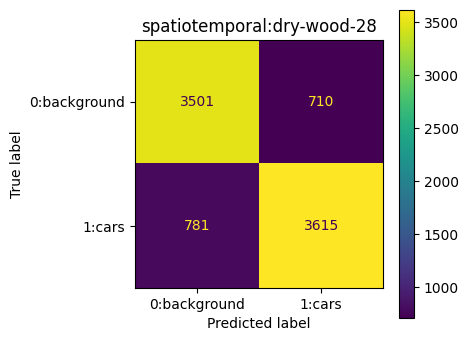

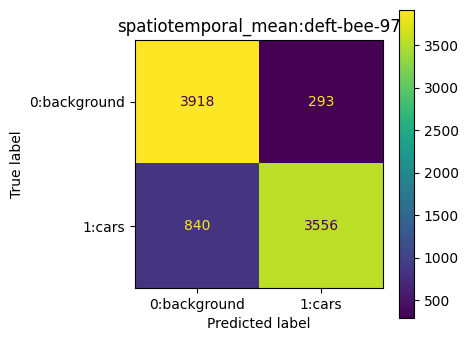

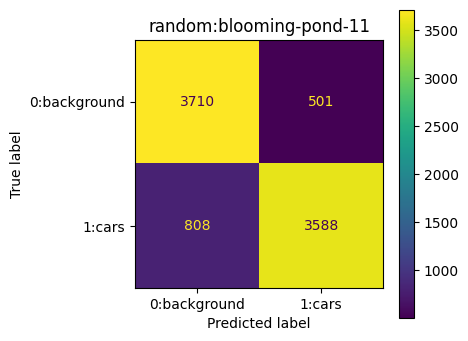

In [19]:
for exp, CM_outputs_list in CM_outputs_dict.items():
    print(f"Results for {exp}:")
    for i, CM_outputs in enumerate(CM_outputs_list):
        print(f"run name: {run_dict[exp][i].name}")
        print(CM_outputs[0])
        print(f"Accraucy: {np.trace(CM_outputs[0])/np.sum(CM_outputs[0])}")
        disp = ConfusionMatrixDisplay(
            confusion_matrix=CM_outputs[0], 
            display_labels = [f'{j}:{c}' for j,c in enumerate(gdm_dict[exp][i].test_dataset.categories)])
        fig, axs = plt.subplots(1, 1, figsize=(4,4))
        disp.plot(ax=axs)
        axs.set_title(f"{exp}:{run_dict[exp][i].name}")
plt.show()

In [20]:
y_true_0 = None
files_0 = None
for key, value in CM_outputs_dict.items():
    if y_true_0 is None:
        y_true_0 = value[0][1]
        files_0 = value[0][3]
    else:
        assert np.isclose(y_true_0, value[0][1]).all(), "y_true is different"
        assert files_0 == value[0][3], "files are different"

In [21]:
ds_dict = {key:gdm_dict[key][0].test_dataset for key in gdm_dict.keys()}
num_vidoes_0 = None
for key, value in ds_dict.items():
    if num_vidoes_0 is None:
        num_vidoes_0 = len(value)      
    else:
        assert num_vidoes_0 == len(value), "number of videos are different"

labels = []
files = []
for v_idx in tqdm(range(num_vidoes_0)):
    file_id_0 = None
    for key, value in ds_dict.items():
        if file_id_0 is None:
            file_id_0 = value[v_idx].file_id
        else:
            assert file_id_0 == value[v_idx].file_id, "file_id is different"
    labels.append(value[v_idx].label[0])
    files.append(value[v_idx].file_id)

  0%|          | 0/8607 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [22]:
y_true = list(CM_outputs_dict.values())[0][0][1]
y_pred_dict = {key: value[0][2] for key, value in CM_outputs_dict.items()}

y_pred_0 = CM_outputs_dict['spatiotemporal_mean'][0][2]
y_pred_1 = CM_outputs_dict['spatiotemporal'][0][2]
y_pred_2 = CM_outputs_dict['random'][0][2]
study_list = []
for i in np.where((y_true == 1) & (y_pred_0 == 0) &  (y_pred_2 == 1))[0]:
    study_list.append((i,osp.join(labels[i],files[i])))
print(len(study_list))
print(study_list)

327
[(np.int64(32), 'cars/obj_003869_td.dat'), (np.int64(47), 'cars/obj_000804_td.dat'), (np.int64(78), 'cars/obj_000145_td.dat'), (np.int64(80), 'cars/obj_000179_td.dat'), (np.int64(89), 'cars/obj_003870_td.dat'), (np.int64(118), 'cars/obj_000702_td.dat'), (np.int64(160), 'cars/obj_002180_td.dat'), (np.int64(195), 'cars/obj_000159_td.dat'), (np.int64(205), 'cars/obj_001110_td.dat'), (np.int64(219), 'cars/obj_000596_td.dat'), (np.int64(224), 'cars/obj_003665_td.dat'), (np.int64(232), 'cars/obj_004045_td.dat'), (np.int64(235), 'cars/obj_000859_td.dat'), (np.int64(266), 'cars/obj_000087_td.dat'), (np.int64(284), 'cars/obj_003987_td.dat'), (np.int64(310), 'cars/obj_001911_td.dat'), (np.int64(334), 'cars/obj_001195_td.dat'), (np.int64(339), 'cars/obj_002467_td.dat'), (np.int64(342), 'cars/obj_000009_td.dat'), (np.int64(359), 'cars/obj_000737_td.dat'), (np.int64(367), 'cars/obj_004101_td.dat'), (np.int64(403), 'cars/obj_001007_td.dat'), (np.int64(405), 'cars/obj_003985_td.dat'), (np.int64(4

In [19]:
from matplotlib import animation
import numpy as np 
import matplotlib.pyplot as plt
from utils.data_utils import is_numpy_event_data, is_pyg_event_data, pyg2numpy_event_convertor

def __animate_events(events, transform, fig_size=None):
    
    
    if is_pyg_event_data(events):
        events = pyg2numpy_event_convertor(events)
    else:
        assert is_numpy_event_data(events), "The input data must be a structured numpy array or a PyG dataset."
    
    frames = transform(events)
    if fig_size is None:
        fig, ax = plt.subplots(1,1)
    else:
        fig, ax = plt.subplots(1,1, figsize=fig_size)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    if frames.shape[1] == 2:
        rgb = np.zeros((frames.shape[0], 3, *frames.shape[2:]))
        rgb[:, 0, ...] = frames[:, 0, ...] > 0
        rgb[:, 2, ...] = frames[:, 1, ...] > 0
        frames = rgb
    if frames.shape[1] in [1, 2, 3]:
        frames = np.moveaxis(frames, 1, 3)
    im = ax.imshow(frames[0])
    # plt.axis("off")
    

    def animate(frame):
        im.set_data(frame)
        return [im]

    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
    plt.close(fig)

    return anim
        

In [20]:
random_idx = torch.randint(0, len(study_list), (1,))
idx = study_list[random_idx][0]
# idx = 2448
print(study_list[random_idx])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


y_hat_dict = {}
data_dict = {}
events_numpy_dict = {}
vox_grid_dict = {}
for key, value in ds_dict.items():
    model = runner_dict[key][0].model
    model.eval()
    with torch.no_grad():
        data = value[idx]
        events_numpy_dict[key] = pyg2numpy_event_convertor(data)
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data.ptr = torch.tensor([0, data.num_nodes], dtype=torch.long)
        data_dict[key] = data
        print(key, data)
        data = data.to(device)
        out = model(data)
        vox_grid = model.quantization_layer.forward(data)
        vox_grid = create_image(vox_grid)
        vox_grid_dict[key] = vox_grid
        label = torch.argmax(out, dim=1)
        y_hat_dict[key] = (label.cpu().item())

print(data.file_id)  
print(data.label[0])
print(data.y)
for key, value in y_hat_dict.items():
    print(key, value)

hight = int(ds_orig[idx].pos[:,1].max().item()) + 5
width = int(ds_orig[idx].pos[:,0].max().item()) + 5

transform = tonic.transforms.ToFrame(
    sensor_size=(3*width, hight, 2),
    time_window=10000,
    # event_count=50,
    overlap=0.5,
)


event_orig = pyg2numpy_event_convertor(ds_orig[idx])

events_numpy_dict['random']['x'] += 0
events_numpy_dict['spatiotemporal_mean']['x'] += 1 * width
event_orig['x'] +=  2 * width
event_all = np.concatenate((events_numpy_dict['random'], 
                            events_numpy_dict['spatiotemporal_mean'], 
                            event_orig), 
                           axis=0)
time_idx = np.argsort(event_all['t'])
event_all = event_all[time_idx]
anim = animate_events(event_all, transform, fig_size=(25,10))
anim.save('animation.gif', writer='imagemagick', fps=30)
HTML(animate_events(event_all, transform, fig_size=(25,10)).to_jshtml())

/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

(np.int64(2179), 'cars/obj_003873_td.dat')
spatiotemporal Data(x=[66, 1], pos=[66, 3], file_id='obj_003873_td.dat', label=[1], y=[1], batch=[66], ptr=[2])
spatiotemporal_mean Data(x=[130, 1], pos=[130, 3], file_id='obj_003873_td.dat', label=[1], y=[1], batch=[130], ptr=[2])
random Data(x=[135, 1], pos=[135, 3], file_id='obj_003873_td.dat', label=[1], y=[1], batch=[135], ptr=[2])
obj_003873_td.dat
cars
tensor([1], device='cuda:0')
spatiotemporal 0
spatiotemporal_mean 0
random 1


MovieWriter imagemagick unavailable; using Pillow instead.


spatiotemporal


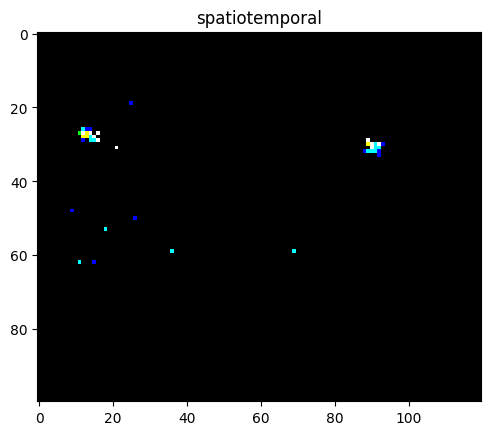

spatiotemporal_mean


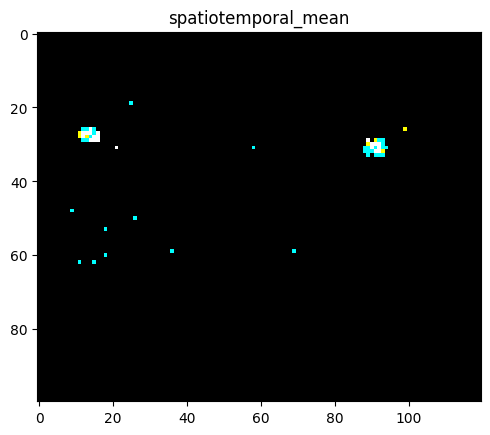

random


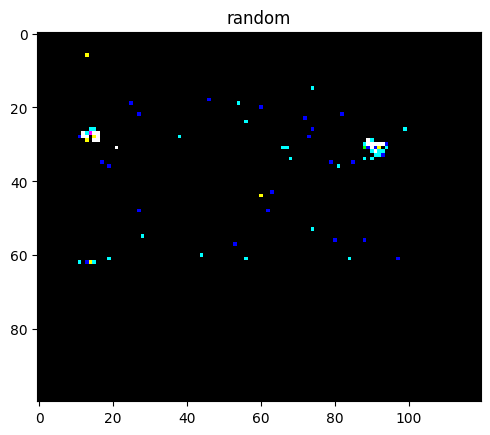

orig


/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

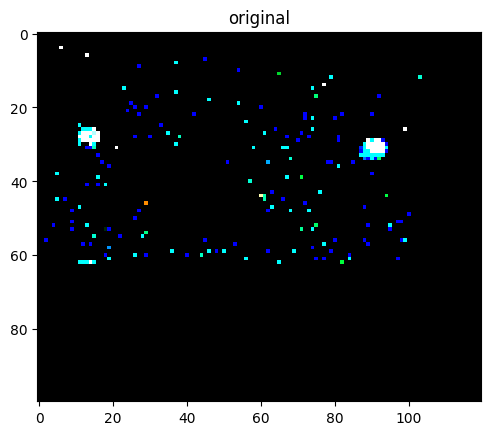

In [21]:
for key,value in vox_grid_dict.items():
    print(key, flush=True)
    fig, axs = plt.subplots(1, 1)
    axs.imshow(value.permute(1,2,0))
    axs.set_aspect('equal', 'box')
    axs.set_title(key)
    plt.show()

with torch.no_grad():
    data = ds_orig[idx]
    data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
    data.ptr = torch.tensor([0, data.num_nodes], dtype=torch.long)
    data = data.to(device)
    vox_grid = model.quantization_layer.forward(data)
    vox_grid = create_image(vox_grid)
print("orig", flush=True)
fig, axs = plt.subplots(1, 1)
axs.imshow(vox_grid.permute(1,2,0))
axs.set_aspect('equal', 'box')
axs.set_title("original")
plt.show()

In [22]:
transform = tonic.transforms.ToFrame(
    sensor_size=(120, 100, 2),
    time_window=10000,
    # event_count=50,
    overlap=0.5,
)
HTML(animate_events(ds_orig[idx], transform).to_jshtml())

In [23]:
print(compute_confusion_matrix(runner_dict['spatiotemporal'][0], gdm_dict['spatiotemporal'][0].test_dataloader()[0])[0])
print(compute_confusion_matrix(runner_dict['spatiotemporal'][0], gdm_dict['spatiotemporal_mean'][0].test_dataloader()[0])[0])
print(compute_confusion_matrix(runner_dict['spatiotemporal'][0], gdm_dict['random'][0].test_dataloader()[0])[0])

100%|██████████| 87/87 [00:21<00:00,  4.14it/s]


tensor(0.8268, device='cuda:0')
[[3501  710]
 [ 781 3615]]


100%|██████████| 87/87 [00:21<00:00,  4.00it/s]


tensor(0.8253, device='cuda:0')
[[3083 1128]
 [ 376 4020]]


100%|██████████| 87/87 [00:21<00:00,  4.10it/s]

tensor(0.8323, device='cuda:0')
[[3813  398]
 [1045 3351]]


In [24]:
print(compute_confusion_matrix(runner_dict['spatiotemporal_mean'][0], gdm_dict['spatiotemporal_mean'][0].test_dataloader()[0])[0])
print(compute_confusion_matrix(runner_dict['spatiotemporal_mean'][0], gdm_dict['spatiotemporal'][0].test_dataloader()[0])[0])
print(compute_confusion_matrix(runner_dict['spatiotemporal_mean'][0], gdm_dict['random'][0].test_dataloader()[0])[0])

  0%|          | 0/87 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tensor(0.8684, device='cuda:0')
[[3918  293]
 [ 840 3556]]


  0%|          | 0/87 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tensor(0.8244, device='cuda:0')
[[3961  250]
 [1261 3135]]


  0%|          | 0/87 [00:00<?, ?it/s]/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

tensor(0.8328, device='cuda:0')
[[4076  135]
 [1304 3092]]


In [25]:
transform_dict = {key:gdm_dict[key][0].test_dataloader()[0].dataset.transform.transforms[0] for key in gdm_dict.keys()}
for key, trnsfrm in transform_dict.items():
    assert torch.allclose(trnsfrm(ds_orig[idx]).pos,ds_dict[key][idx].pos), f"{key} transform is not correct"

/home/hesam/Projects/DGCNN_CV_format/subsampling_figures/../datasets_torch_geometric/base_dataset.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(sel

In [24]:
num_event_dict = {}
labels_dict = {}
for key, value in ds_dict.items():
    num_event_dict[key] = []
    labels_dict[key] = []
    for i in range(len(ds_dict[key])):
        num_event_dict[key].append(ds_dict[key][i].num_nodes)
        labels_dict[key].append(ds_dict[key][i].label[0]) 
    num_event_dict[key] = np.array(num_event_dict[key])
num_event_dict['orig'] = []
labels_dict['orig'] = []
for i in range(len(ds_orig)):
    num_event_dict['orig'].append(ds_orig[i].num_nodes)
    labels_dict['orig'].append(ds_orig[i].label[0])        
num_event_dict['orig'] = np.array(num_event_dict['orig'])
labels_0 = labels_dict['orig']
for key, value in labels_dict.items():
    assert labels_0 == value, f"labels are different for {key}"

In [25]:
print('type', ' '*(20-len('type')),
        '****  mean  ****', '\t\t',
        '****  std  ****', '\t',
        'min', '\t',
        'max', '\t',
        'median')
print('-'*100)
for key, value in num_event_dict.items():
    print(key, ' '*(20-len(key)),
          np.mean(value), '\t',
          np.std(value), '\t',
          np.min(value), '\t',
          np.max(value), '\t',
          np.median(value))


type                  ****  mean  **** 		 ****  std  **** 	 min 	 max 	 median
----------------------------------------------------------------------------------------------------
spatiotemporal        294.18624375508307 	 607.0569374443568 	 1 	 17107 	 105.0
spatiotemporal_mean   1014.9491111885675 	 1082.1918514780311 	 103 	 14715 	 636.0
random                338.9388869524805 	 361.22922921895616 	 28 	 4840 	 212.0
orig                  4067.7325432787266 	 4335.566786406965 	 500 	 59249 	 2545.0


In [28]:
np.corrcoef(num_event_dict['random'],num_event_dict['spatiotemporal_mean'])

array([[1.        , 0.99935624],
       [0.99935624, 1.        ]])

In [29]:
np.corrcoef(num_event_dict['random'],num_event_dict['spatiotemporal'])

array([[1.        , 0.88396436],
       [0.88396436, 1.        ]])

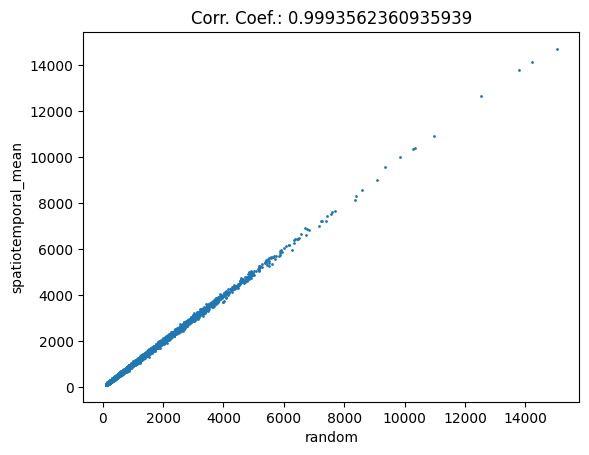

In [30]:
plt.scatter(num_event_dict['random'],num_event_dict['spatiotemporal_mean'], s=1)
plt.title(f"Corr. Coef.: {np.corrcoef(num_event_dict['random'],num_event_dict['spatiotemporal_mean'])[0,1]}")
plt.xlabel('random')
plt.ylabel('spatiotemporal_mean')
plt.show()

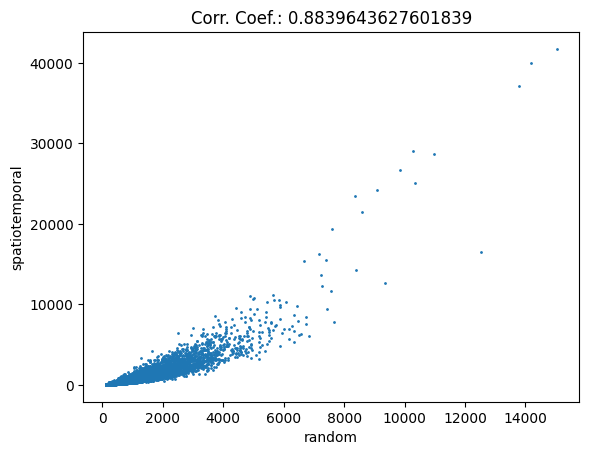

In [31]:
plt.scatter(num_event_dict['random'],num_event_dict['spatiotemporal'], s=1)
plt.title(f"Corr. Coef.: {np.corrcoef(num_event_dict['random'],num_event_dict['spatiotemporal'])[0,1]}")
plt.xlabel('random')
plt.ylabel('spatiotemporal')
plt.show()

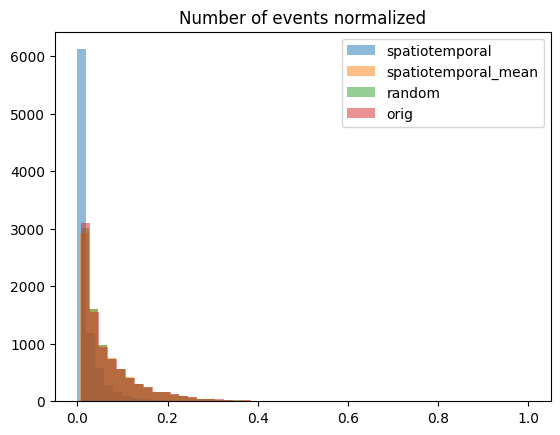

In [32]:
for key, n_e in num_event_dict.items():
    plt.hist(n_e/n_e.max(), bins=50, alpha=0.5, label=key)
plt.legend(loc='upper right')
plt.title('Number of events normalized')
plt.show()


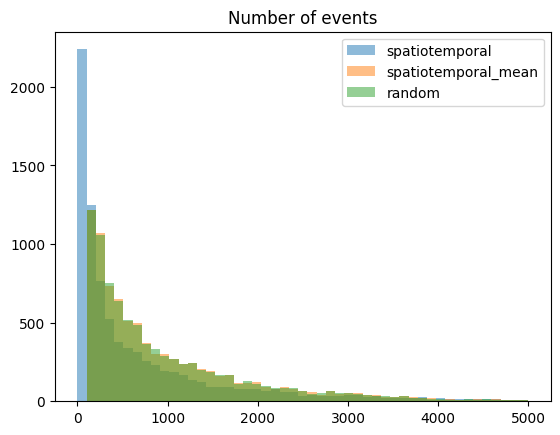

In [74]:
bins = np.linspace(0, 5000, 50)
for key, n_e in num_event_dict.items():
    if key == 'orig':
        continue
    plt.hist(n_e, bins=bins, alpha=0.5, label=key)
plt.legend(loc='upper right')
plt.title('Number of events')
plt.show()

In [26]:
bins = np.linspace(0, 2500, 50)
spatio_correct = np.where(y_true == y_pred_spatio)[0]
plt.hist(num_event_spatio[spatio_correct], bins=bins, alpha=0.5, label='spatiotemporal')
random_correct = np.where(y_true == y_pred_random)[0]
plt.hist(num_event_random[random_correct], bins=bins, alpha=0.5, label='random')
plt.legend()
plt.title('Number of events for correct predictions')
plt.show()

NameError: name 'y_pred_spatio' is not defined

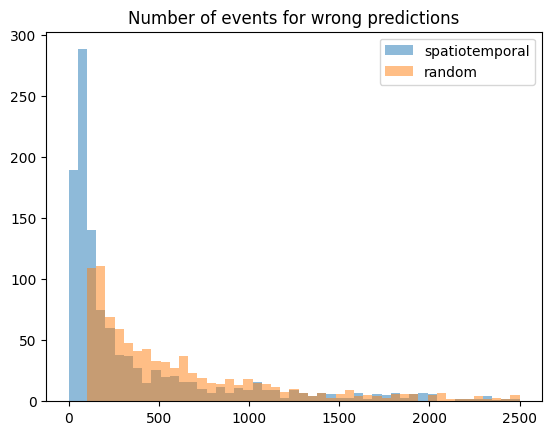

In [76]:
bins = np.linspace(0, 2500, 50)
spatio_mistake = np.where(y_true != y_pred_spatio)[0]
plt.hist(num_event_spatio[spatio_mistake], bins=bins, alpha=0.5, label='spatiotemporal')
random_mistake = np.where(y_true != y_pred_random)[0]
plt.hist(num_event_random[random_mistake], bins=bins, alpha=0.5, label='random')
plt.legend()
plt.title('Number of events for wrong predictions')
plt.show()

In [ ]:
CM_outputs_dict
num_event_dict
y_pred_dict
y_true

In [ ]:
torch.save({'CM_outputs_dict': CM_outputs_dict,
            'num_event_dict': num_event_dict,
            'y_pred_dict': y_pred_dict,
            'y_true': y_true}, 'NCARS_acc_num_events.pt')
CM_outputs_dict, num_event_dict, y_pred_dict, y_true = torch.load('NCARS_acc_num_events.pt')

In [51]:
# Load dictionary
data = torch.load('NCARS_acc_num_events.pt')

# Extract data properly
CM_outputs_dict = data.get('CM_outputs_dict')
num_event_dict = data.get('num_event_dict')
y_pred_dict = data.get('y_pred_dict')
y_true = data.get('y_true')

num_event_spatio = num_event_dict['spatiotemporal']
y_pred_spatio = y_pred_dict['spatiotemporal']
num_event_random = num_event_dict['random']
y_pred_random = y_pred_dict['random']
num_event_spatio_mean = num_event_dict['spatiotemporal_mean']
y_pred_spatio_mean = y_pred_dict['spatiotemporal_mean']


/tmp/ipykernel_15649/826287995.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('NCARS_acc_num_events.pt')


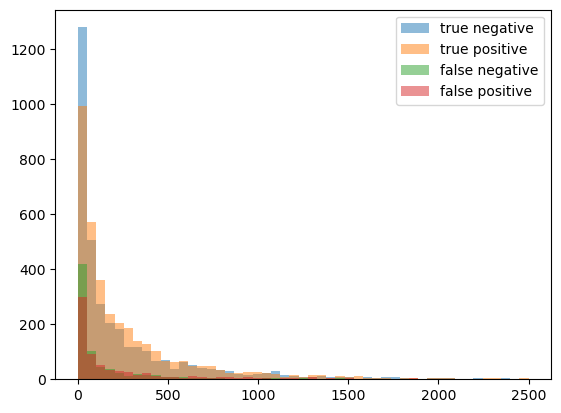

In [ ]:
bins = np.linspace(0, 2500, 50)
idx_true_neg = np.where((y_true == 0) & (y_pred_sptio == 0))[0]
plt.hist(num_event_spatio[idx_true_neg], bins=bins, alpha=0.5, label='true negative')
idx_true_pos = np.where((y_true == 1) & (y_pred_sptio == 1))[0]
plt.hist(num_event_spatio[idx_true_pos], bins=bins, alpha=0.5, label='true positive')
idx_false_neg = np.where((y_true == 1) & (y_pred_sptio == 0))[0]
plt.hist(num_event_spatio[idx_false_neg], bins=bins, alpha=0.5, label='false negative')
idx_false_pos = np.where((y_true == 0) & (y_pred_sptio == 1))[0]
plt.hist(num_event_spatio[idx_false_pos], bins=bins, alpha=0.5, label='false positive')
plt.legend()
plt.show()

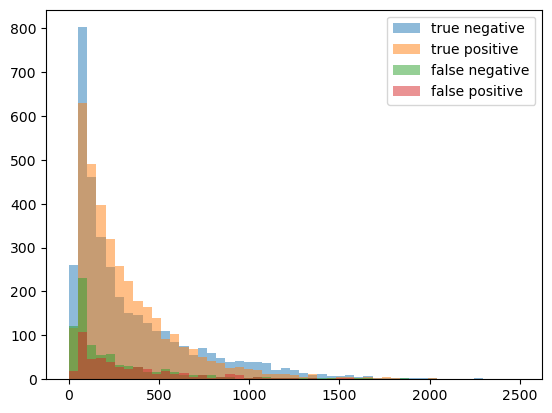

In [ ]:
bins = np.linspace(0, 2500, 50)
idx_true_neg = np.where((y_true == 0) & (y_pred_random == 0))[0]
plt.hist(num_event_random[idx_true_neg], bins=bins, alpha=0.5, label='true negative')
idx_true_pos = np.where((y_true == 1) & (y_pred_random == 1))[0]
plt.hist(num_event_random[idx_true_pos], bins=bins, alpha=0.5, label='true positive')
idx_false_neg = np.where((y_true == 1) & (y_pred_random == 0))[0]
plt.hist(num_event_random[idx_false_neg], bins=bins, alpha=0.5, label='false negative')
idx_false_pos = np.where((y_true == 0) & (y_pred_random == 1))[0]
plt.hist(num_event_random[idx_false_pos], bins=bins, alpha=0.5, label='false positive')
plt.legend()
plt.show()